In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nishimapanwar","key":"3546858fead684e47e688287fd95c1de"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              233KB  2021-07-07 19:18:09           9237  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           5654  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2052  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2404  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [7]:
!kaggle datasets download -d gpiosenka/100-bird-species

100% 1.81G/1.81G [00:15<00:00, 89.9MB/s]
100% 1.81G/1.81G [00:15<00:00, 125MB/s] 


In [8]:
!unzip 100-bird-species.zip

Streaming output truncated to the last 5000 lines.
  inflating: birds_rev2/train/TOWNSENDS WARBLER/091.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/092.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/093.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/094.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/095.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/096.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/097.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/098.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/099.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/100.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/101.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/102.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/103.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/104.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/105.jpg  
  inflating: birds_rev2/train/TOWNSENDS WARBLER/106.jpg  
  inflating: birds_re

In [9]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import time
import copy
import torch
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torchvision.transforms as transform


In [10]:
transform = transform.Compose([transform.RandomHorizontalFlip(),
                                transform.RandomRotation(0.2),
                                transform.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transform.Resize((80,80))
                               ])

In [11]:
if torch.cuda.is_available():
    dev = "cuda:0"  
else:
    dev = "cpu"
device = torch.device(dev)

In [12]:
train= torchvision.datasets.ImageFolder(root="/content/birds/train", transform=transform)
test= torchvision.datasets.ImageFolder(root="/content/birds/test", transform=transform)

In [13]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=32,shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(val,batch_size=32,shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test,batch_size=32,shuffle=False)

dataloaders = {
    "train": train_data_loader,
    "test": test_data_loader
}
datasizes = {
    "train": len(train),
    "test": len(test)
}
CLASSES = list(train.class_to_idx.keys())

In [14]:
def imshow(img, size=(10, 10)):
    img = img / 2 + 0.5
    npimg = img.numpy()
    if size:
        plt.figure(figsize=size)
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("One mini batch")
    plt.axis("off")
    plt.pause(0.001)

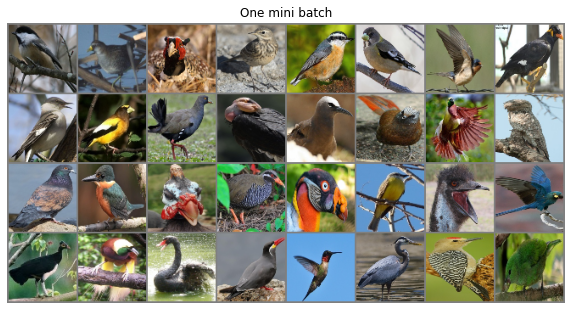

In [15]:
dataiter = iter(train_data_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [16]:
cuda = False
if torch.cuda.is_available():
    cuda = True


In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(5*5*128, 1600)
        self.fc2 = nn.Linear(1600, 3200)
        self.fc3 = nn.Linear(3200, len(CLASSES))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [18]:
model = Net()
if cuda==True:
    model.cuda()

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [20]:
num_epochs=10

In [21]:
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
model = Net().to(device)

In [23]:
total_step = len(train_data_loader)
for epoch in range(num_epochs):
    model.train()
    training_accuracy=0
    val_accuracy=0
    for i, (images, labels) in enumerate(train_data_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
       
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
    
        
        preds = outputs.data.max(dim = 1, keepdim = True)[1]
        training_accuracy += preds.eq(labels.data.view_as(preds)).cpu().sum()
        
        
    training_accuracy = training_accuracy/len(train_data_loader.dataset) * 100
        
    print ('Epoch [{}/{}], Loss: {:.4f}, Training Accuracy: {}' 
                   .format(epoch+1, num_epochs, loss.item(), training_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/10], Loss: 5.4739, Training Accuracy: 0.32262980937957764
Epoch [2/10], Loss: 5.6541, Training Accuracy: 0.3023066818714142
Epoch [3/10], Loss: 5.6348, Training Accuracy: 0.353114515542984
Epoch [4/10], Loss: 5.6677, Training Accuracy: 0.3200894296169281
Epoch [5/10], Loss: 5.6578, Training Accuracy: 0.31500864028930664
Epoch [6/10], Loss: 5.4181, Training Accuracy: 0.3175490200519562
Epoch [7/10], Loss: 5.4687, Training Accuracy: 0.353114515542984
Epoch [8/10], Loss: 5.9419, Training Accuracy: 0.32517021894454956
Epoch [9/10], Loss: 5.5905, Training Accuracy: 0.2972258925437927
Epoch [10/10], Loss: 5.7755, Training Accuracy: 0.34041255712509155


In [24]:
model.train()  
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Train Accuracy of the model on the 8000 test images with Relu is: {} %'.format(100 * correct / total))

Train Accuracy of the model on the 8000 test images with Relu is: 0.2997662839142364 %


In [25]:
total_step = len(test_data_loader)
for epoch in range(num_epochs):
    model.eval()
    test_accuracy=0
    val_accuracy=0
    for i, (images, labels) in enumerate(test_data_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
       
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
       
        preds = outputs.data.max(dim = 1, keepdim = True)[1]
        test_accuracy += preds.eq(labels.data.view_as(preds)).cpu().sum()
        
        
    test_accuracy = test_accuracy/len(test_data_loader.dataset) * 100
        
    print ('Epoch [{}/{}], Loss: {:.4f}, Testing Accuracy: {}' 
                   .format(epoch+1, num_epochs, loss.item(), test_accuracy))

Epoch [1/10], Loss: 5.5882, Testing Accuracy: 0.4363636374473572
Epoch [2/10], Loss: 5.6118, Testing Accuracy: 0.2181818187236786
Epoch [3/10], Loss: 5.5948, Testing Accuracy: 0.290909081697464
Epoch [4/10], Loss: 5.6186, Testing Accuracy: 0.145454540848732
Epoch [5/10], Loss: 5.6046, Testing Accuracy: 0.072727270424366
Epoch [6/10], Loss: 5.6041, Testing Accuracy: 0.4363636374473572
Epoch [7/10], Loss: 5.6079, Testing Accuracy: 0.2181818187236786
Epoch [8/10], Loss: 5.6183, Testing Accuracy: 0.3636363744735718
Epoch [9/10], Loss: 5.6063, Testing Accuracy: 0.2181818187236786
Epoch [10/10], Loss: 5.5897, Testing Accuracy: 0.290909081697464


In [26]:
model.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 8000 test images with Relu is: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 8000 test images with Relu is: 0.3404125596992176 %
